# MUWCLASS Pipeline on CSCv2 Demonstration
### Hui Yang1, Jeremy Hare2, Oleg Kargaltsev1, Igor Volkov1
### 1 The George Washington University 2 NASA GSFC

This notebook presents a demonstration of classifying Chandra Source Catalog v2 (CSCv2) using the MUltiWavelength Machine Learning CLASSification Pipeline with CSCv2 and multiwavelength data

* This notebook was run in CIAO 4.14 with Python 3.9 
* run 'bash install-packages.sh' under CIAO 4.14 environment to install all required packages 



In [2]:
import numpy as np
import pandas as pd

import astropy
from astropy import units as u
from astropy.coordinates import SkyCoord
import astroquery
from astropy.table import QTable
import pyvo as vo
import pyds9 as ds9

import time
from pathlib import Path
import multiprocessing as mp

import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image, display
import seaborn as sns
import ipyaladin.aladin_widget as ipyal

from test_library import class_prepare, class_train_and_classify, class_save_res, prepare_cols
from other_libaray import prepare_field, dict_update, combine_class_result, plot_bbsed, plot_class_matrix, prepare_evts_plot_xray_class, interactive_Ximg_class

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [3]:
print("Versions:")
print(f"  NumPy       - {np.__version__}")
print(f"  Matplotlib  - {matplotlib.__version__}")
print(f"  AstroPy     - {astropy.__version__}")
print(f"  PyDS9       - {vo.__version__}")
print(f"  Astroquery  - {astroquery.__version__}")
print(f"  Seaborn     - {sns.__version__}")

Versions:
  NumPy       - 1.22.1
  Matplotlib  - 3.5.1
  AstroPy     - 5.0
  PyDS9       - 1.2.1
  Astroquery  - 0.4.5
  Seaborn     - 0.11.2


#### define a circular region of interest with detections available from CSCv2 ACIS chips

* field_name
* ra_field, dec_field, radius: coordinates and radius (in arcmin) of the field

In [4]:
#field_name = 'NGC3532'
#ra_field, dec_field, radius =166.28875, -58.85, 12

field_name ='J1023-575'
ra_field, dec_field,radius = 155.813263,-57.776329,0.166337*60

#field_name = 'Trumpler18'
#ra_field, dec_field,radius = 167.8665, -60.66655, 12

data_dir = f'./data/{field_name}' # data directory to save the file

dir_out = f'./{field_name}_results' # classification results directory
dir_plot = dir_out+'/plot' # plots directory
Path(dir_out).mkdir(parents=True, exist_ok=True)
Path(dir_plot).mkdir(parents=True, exist_ok=True)


#### Cone search 

* query with the PyVo package 
* only significant X-ray sources (significance>5) are selected for classification
* prepare_field extracts per-observation CSC data, calculates average X-ray fluxes and hardness ratio, X-ray variability from multiple X-ray detections, and applies cross-matching with multiwavelength catalogs (GAIA, 2MASS, WISE)

In [6]:

cone = vo.dal.SCSService('http://cda.cfa.harvard.edu/csc2scs/coneSearch')
field = SkyCoord(ra_field, dec_field, unit="deg") 
maxrad = radius * u.arcmin
results = cone.search(pos=field, radius=maxrad, verbosity=2)
df_res = results.to_table().to_pandas()
df_sig = df_res[df_res.significance>5].reset_index()
print(len(df_sig),'with S/N >5 among',len(df_res))
df_MW = prepare_field(df_sig, data_dir, './data/query', field_name, name_col='name',search_mode='cone_search')


198 with S/N >5 among 815
Run cal_ave......
There are 773 per-obs data.
Run flux2symmetric......
Run flux2symmetric......
Run powlaw2symmetric......
Run apply_flags_filter......
After dropping 0 detections with HRC instrument, 773 remain.
After dropping 3 detections with theta larger than 10', 770 remain.
After dropping 0  detections with sat_src_flag = TRUE, 770 remain.
After dropping 0  detections with pile_warning>0.3, 770 remain.
After dropping 0  detections with streak_src_flag = TRUE, 770 remain.
After dropping 20  detections assigned to different sources, 752 remain.
Run cal_sig......
Run cal_aveflux......
Run cal_aveflux......
Run cal_var......
Run nan_flux......
0.019518613815307617
gaia
145 MW counterparts remained for gaia
2mass
107 MW counterparts remained for 2mass
catwise
16 MW counterparts remained for catwise
unwise
17 MW counterparts remained for unwise
allwise
10 MW counterparts remained for allwise
198  sources in total.
remove_code = 1: CSC flags
24 sources with Tru

#### read field data, training data and absroption file that is need to calculate absorption correction 

In [7]:
field = pd.read_csv(f'{data_dir}/{field_name}_MW_remove.csv')
field = prepare_cols(field, cp_thres=0, vphas=False,gaiadata=False) # apply with some filterings

TD = pd.read_csv('./data/TD/CSC_TD_MW_demo.csv')
TD = prepare_cols(TD, cp_thres=0, TD=True, NS_MWdrop=False, STAR_classremove=['HM-STAR','LM-STAR','YSO']) # some filtering 

# tbabs from xpsec Wilms, Allen & McCray (2000)
tbabs_ene, tbabs_cross = np.loadtxt('./data/tools/tbabs.data', skiprows=0)
tbabs_cross *= 100


Remove 21 [('LM-STAR', 1), ('YSO', 20)]
Final breakdown 2941 [('AGN', 1390), ('CV', 44), ('HM-STAR', 118), ('HMXB', 26), ('LM-STAR', 207), ('LMXB', 65), ('NS', 87), ('YSO', 1004)]


#### MUWCLASS pipeline settings

In [8]:
Xcat = 'CSC' # CSCv2 catalog is used 
Uncer_flag = True # applying Monte-Carlo samplings to account the measurement uncertainties 
num_sample = 100 # number of MC samplings
class_labels = ['AGN','CV','HM-STAR','LM-STAR','HMXB','LMXB','NS','YSO'] # there are 8 classes of X-ray sources in our current pipeline 


#### preprocessing 

In [9]:
num_cores = mp.cpu_count()
pool = mp.Pool(int(num_cores))

%time arr = [pool.apply(class_prepare, args=(TD, field, True, ra_field, dec_field, Xcat, 'nodist', Uncer_flag, i, i, tbabs_ene, tbabs_cross)) for i in range(num_sample)]


CPU times: user 993 ms, sys: 477 ms, total: 1.47 s
Wall time: 30.9 s


#### Random Forest Algorithm hyper-parameter setting

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [10]:
opts = {'bootstrap': True, 'class_weight': None, 'criterion': 'gini',
        'max_depth': 15, 'max_features': "auto", 'max_leaf_nodes': None,
        'min_samples_leaf': 3, 'min_samples_split': 5,
        'min_weight_fraction_leaf': 0.0, 'n_jobs': None,#-1,
        'random_state': None , 'verbose': 0, 'warm_start': False,
        'n_estimators': 300}

#### running the classification (training, applying model to field data and saving classification results )

In [11]:
%%time

arr2 = list(zip(arr, [dict_update(opts, {'random_state': i}) for i in range(len(arr))]))

if __name__ == '__main__':
    
    with mp.Pool() as pool:
        res = pool.map(class_train_and_classify, arr2) 

class_save_res(res, dir_out)

CPU times: user 559 ms, sys: 508 ms, total: 1.07 s
Wall time: 38.3 s


#### combining the classification (MC samplings provide the ability to calculate uncertainties on classification probability) & saving the file for XCLASS

In [12]:
field_mw_class = combine_class_result(field_name, data_dir, dir_out, class_labels)

field_XCLASS = field_mw_class.rename(columns={'significance':'Signif.','Fcsc_s':'F_s','Fcsc_m':'F_m','Fcsc_h':'F_h','flux_aper90_ave_b':'F_b','var_intra_prob':'P_intra', 'var_inter_prob':'P_inter',
       'Gmag':'G','BPmag':'BP','RPmag':'RP','Jmag':'J','Hmag':'H','Kmag':'K','W1mag':'W1','W2mag':'W2','W3mag':'W3','W4mag':'W4'})

#field_XCLASS[['name','ra','dec','Class','F_b','F_h','F_m','F_s','P_inter','P_intra','Signif.','G','BP','RP','J','H','K','W1','W2','W3']].to_csv(f'{dir_out}/{field_name}_XCLASS.csv')

field_XCLASS.loc[field_XCLASS.conf_flag>0,['name','ra','dec','Class','F_b','F_h','F_m','F_s','P_inter','P_intra','Signif.','G','BP','RP','J','H','K','W1','W2','W3']].to_csv(f'{dir_out}/{field_name}_XCLASS.csv')


## Visualization of classification results 

### MUWCLASS pipeline performance evaluation 

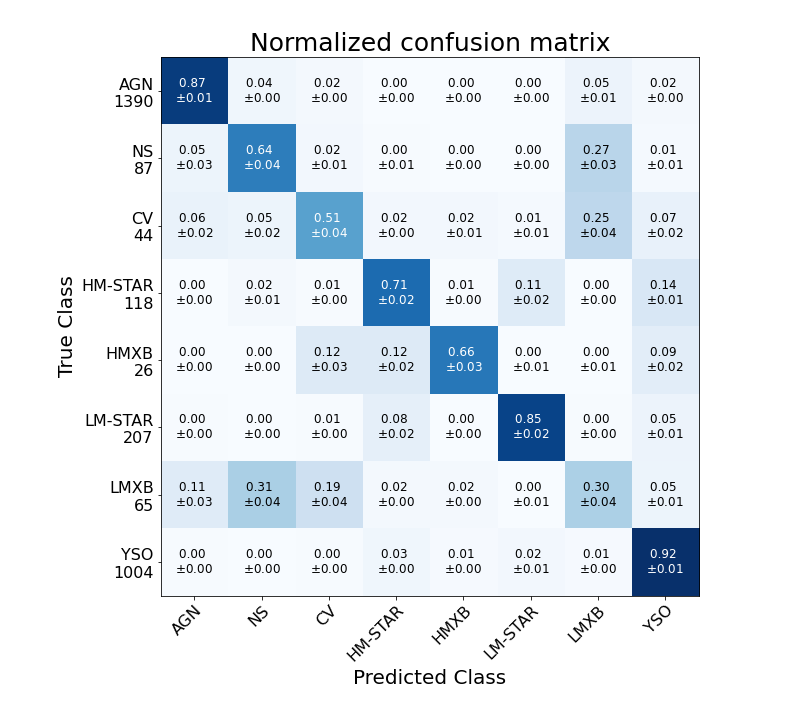

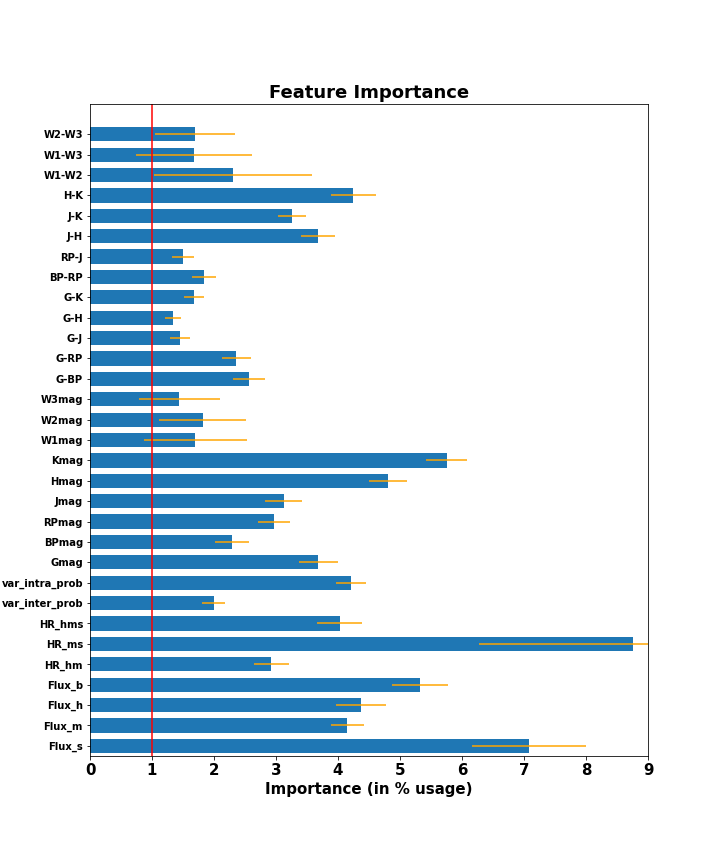

In [13]:
# confusion matrix 
display(Image(filename='./data/TD/LOO_CSC_100ave_CM_02282022.png'))

# feature importance
display(Image(filename='./data/TD/fea_imp_CSC_100ave_02282022.png'))

#### XCLASS interactive plotting GPI of TD overplotted with field data 

In [14]:
%%html
<iframe src="https://home.gwu.edu/~kargaltsev/XCLASS/" width="1200" height="1200"></iframe>

# click on Choose File and upload {dir_out}/{field_name}_XCLASS.csv to overplot the field data


#### multi-band spectrum of TD overplotted with field data 
* set plot_class the class of sources that you want to plot the broadband SED 

In [ ]:
plot_bbsed(TD, field_mw_class, dir_plot, plot_class='YSO', save_class=[], confidence=True, TD_name_col=False)
    

#### create the classification matrix and save it to the plot directory

In [16]:
plot_class_matrix(field_name, field_mw_class, dir_plot, class_labels)

#### The histograms of all and confident classifications 

<AxesSubplot:title={'center':'confident classification'}>

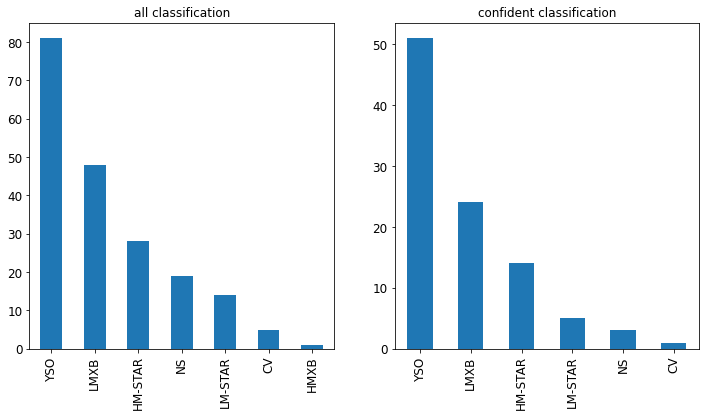

In [17]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
field_mw_class['Class'].value_counts().plot(kind='bar', ax=ax1, title='all classification')
field_mw_class[field_mw_class.conf_flag>0]['Class'].value_counts().plot(kind='bar', ax=ax2,title='confident classification')


#### prepare the event file and plot X-ray image with classification results overplotted

In [18]:
evt2_data,  fn_evt2 = prepare_evts_plot_xray_class(field_name, ra_field, dec_field, radius, data_dir, dir_out)

ha
[12151] []


bash: to_merge.sh: No such file or directory


#### plotting multi-band field images with ipyaladin 

In [19]:
aladin = ipyal.Aladin(target=str(ra_field)+' '+str(dec_field), fov=radius/20)


dtb = QTable.from_pandas(field_mw_class)

aladin

Aladin(fov=0.49901100000000004, options=['allow_full_zoomout', 'coo_frame', 'fov', 'full_screen', 'log', 'over…

In [20]:
aladin.add_table(dtb)

#### Interactive plotting of X-ray image overplotted with classification results 

In [ ]:
interactive_Ximg_class(field_name, evt2_data, fn_evt2, dir_out)